In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    FluxPointsDataset,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    SkyModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [2]:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': '--',
})

# Load DL3 data file

In [3]:
# === Settings ===
dl3_dir = '/home/yoshiki.ohtani/software/magic-cta-pipe/magicctapipe/scripts/lst1_magic/dl3_gam_global0.6/'

# === Main ===
datastore = DataStore.from_dir(dl3_dir)

obs_ids = datastore.obs_table['OBS_ID'].value
observations = datastore.get_observations(obs_ids, required_irf=['aeff', 'edisp'])

print(observations)

No HDU found matching: OBS_ID = 5093711, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093711, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093711, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093712, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093712, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093712, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093713, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 5093714, HDU_TYPE = rad_max, HDU_CLASS = None


Observations
Number of observations: 4
Observation

	obs id            : 5093711 
 	tstart            : 59198.89
	tstop             : 59198.90
	duration          : 864.68 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.0%
Observation

	obs id            : 5093712 
 	tstart            : 59198.90
	tstop             : 59198.91
	duration          : 846.19 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 0.0%
Observation

	obs id            : 5093713 
 	tstart            : 59198.92
	tstop             : 59198.93
	duration          : 816.03 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 0.0%
Observation

	obs id            : 5093714 
 	tstart            : 59198.93
	tstop             : 59198.94
	duration          : 776.30 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 0.0%



# Define a target region

In [4]:
# === Settings ===
target_source_name = 'Crab'

# target_source_lon = u.Quantity(83.63, u.deg)
# target_source_lat = u.Quantity(22.01, u.deg)
# target_source_frame = 'icrs'

# === Main ===
if target_source_name is not None:
    print(f'Get the target position from the source name: {target_source_name}\n')
    target_position = SkyCoord.from_name(target_source_name)
    target_position = target_position.transform_to('icrs')
else:
    print('Set the target position with the input values...\n')
    target_position = SkyCoord(target_source_lon, target_source_lat, frame=target_source_frame)
    
# Define an on-region radius.
# Here it assumes that the IRFs are created with a global theta cut:
base_dir = datastore.hdu_table[0].meta['BASE_DIR']
file_name = datastore.hdu_table[0]['FILE_NAME']

file_path = Path(base_dir) / Path(file_name)
on_region_radius = u.Quantity(Table.read(file_path, hdu='EFFECTIVE AREA').meta['RAD_MAX'], u.deg)

on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

print(on_region)

Get the target position from the source name: Crab

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>
radius: 0.2 deg


# Create an exclusion mask

Get the exclusion position from the source name: RGB J0521+212

Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (80.44152391, 21.21429244)>
radius: 0.5 deg


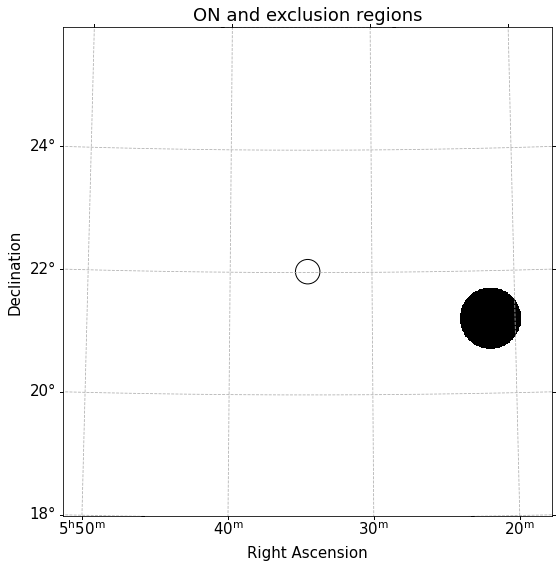

In [5]:
# === Settings ===
exclusion_position_name = 'RGB J0521+212'

# exclusion_position_lon = u.Quantity(183.604, u.deg)
# exclusion_position_lat = u.Quantity(-8.708, u.deg)
# exclusion_position_frame = 'galactic'

exclusion_region_radius = u.Quantity(0.5, u.deg)

# === Main ===
if exclusion_position_name is not None:
    print(f'Get the exclusion position from the source name: {exclusion_position_name}\n')
    exclusion_position = SkyCoord.from_name(exclusion_position_name)
    exclusion_position = exclusion_position.transform_to('icrs')
else:
    print('Set the exclusion position with the input values...\n')
    exclusion_position = SkyCoord(
        exclusion_position_lon, exclusion_position_lat, frame=exclusion_position_frame,
    )
    
exclusion_region = CircleSkyRegion(center=exclusion_position, radius=exclusion_region_radius)

print(exclusion_region)

geom = WcsGeom.create(
    npix=(800, 800), binsz=0.01,
    skydir=target_position, proj='TAN', frame='icrs',
)

exclusion_mask = ~geom.region_mask([exclusion_region])

# Plot the region:
plt.figure()

ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor='black')

ax.set_title('ON and exclusion regions')
ax.grid()

# Run data reduction chain

In [6]:
# === Settings ===
energy_reco_min = 0.01
energy_reco_max = 10
n_bins_reco = 5

energy_true_min = 0.01
energy_true_max = 100
n_bins_true = 5

# === Main ===
energy_axis = MapAxis.from_energy_bounds(
    energy_reco_min, energy_reco_max, nbin=n_bins_reco, per_decade=True, unit='TeV', name='energy',
)

energy_axis_true = MapAxis.from_energy_bounds(
    energy_true_min, energy_true_max, nbin=n_bins_true, per_decade=True, unit='TeV', name='energy_true',
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

# Define the SpectrumDatasetMaker, assuming tha the input is point-like IRFs.
# Even if the "use_region_center" is set to True, there is the following warning but is safely ignored:
# "MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate"
# This issue has been already fixed in the master branch and it will not appear in the coming version of gammapy:

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=['counts', 'exposure', 'edisp'], use_region_center=True,
)

bkg_maker = ReflectedRegionsBackgroundMaker(
    exclusion_mask=exclusion_mask, min_distance=u.Quantity(100, u.deg), max_region_number=1,
)

safe_mask_maker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)

print(dataset_maker)

SpectrumDatasetMaker
--------------------

  selection               : {'edisp', 'exposure', 'counts'}
  containment_correction  : False
  background_oversampling : None
  use_region_center       : True



In [7]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
    
    datasets.append(dataset_on_off)

print(datasets)

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.
MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 5093711
  Instrument : CTA-N
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 5093712
  Instrument : CTA-N
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 5093713
  Instrument : CTA-N
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 5093714
  Instrument : CTA-N
  Models     : 




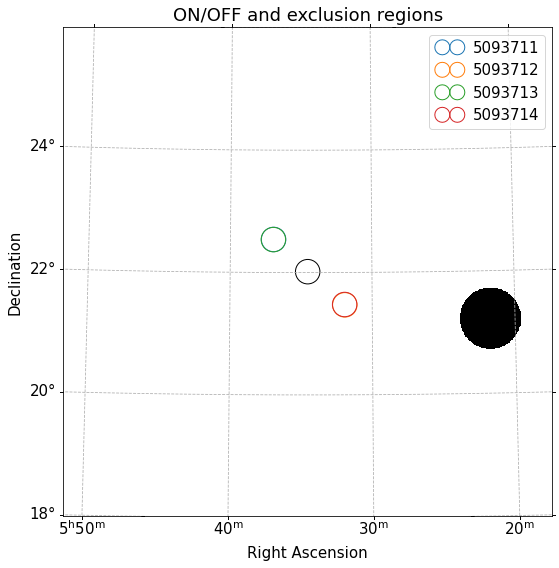

In [8]:
plt.figure()

ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor='black')

plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

ax.set_title('ON/OFF and exclusion regions')
ax.grid()

# Source statistics

In [9]:
info_table = datasets.info_table(cumulative=True)

In [10]:
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,407,147.0,260.0,11.267196483937296,277.0,277.0,nan,443.70599365234375,281753312.0,864.6775097846985,864.6775097846985,0.47069571648896186,0.17000557819134496,0.3006901382976169,15,9,wstat,150.72647822760072,147,9.0,9.0,1.0
stacked,770,271.0,499.0,15.78978298938084,520.5,520.5,nan,877.9227294921875,557480960.0,1710.8628103733063,1710.8628103733063,0.4500653093464506,0.1583996088738807,0.29166570047256996,15,9,wstat,280.48344157032835,271,9.0,9.0,1.0
stacked,1151,401.0,750.0,19.443589044436468,776.0,776.0,nan,1296.6668701171875,823383488.0,2526.8956434726715,2526.8956434726715,0.4554996178703286,0.15869274262901978,0.29680687524130883,15,9,wstat,411.8985620797633,401,9.0,9.0,1.0
stacked,1469,500.0,969.0,22.321994341573298,984.5,984.5,nan,1695.020263671875,1076337920.0,3303.1917695999146,3303.1917695999146,0.4447213793396944,0.15136874722249638,0.293352632117198,15,9,wstat,539.80885508825,500,9.0,9.0,1.0


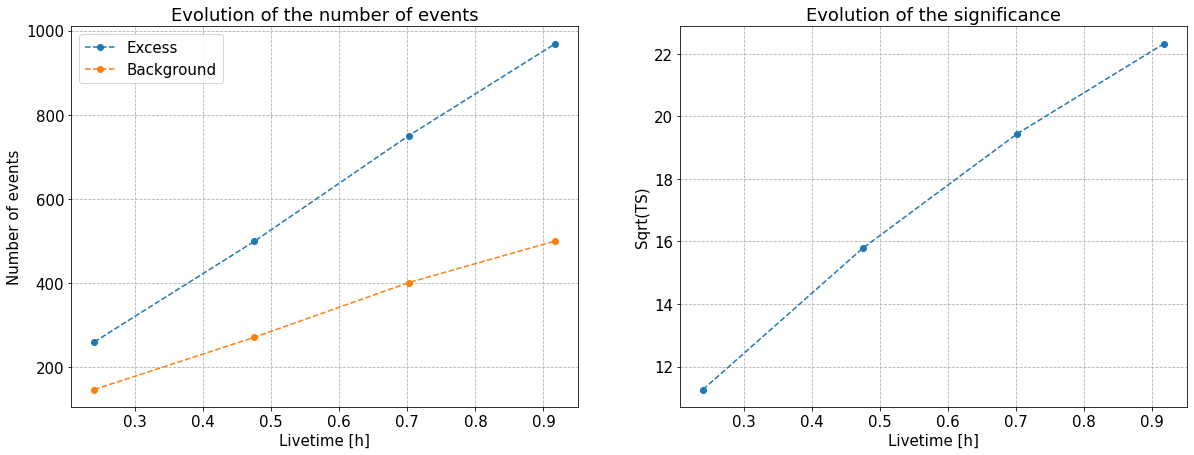

In [11]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Livetime vs N events:
plt.subplot2grid(grid, (0, 0))
plt.title('Evolution of the number of events')
plt.xlabel('Livetime [h]')
plt.ylabel('Number of events')

plt.plot(
    info_table['livetime'].to('h'), info_table['excess'],
    marker='o', linestyle='--', label='Excess'
)

plt.plot(
    info_table['livetime'].to('h'), info_table['background'],
    marker='o', linestyle='--', label='Background',
)

plt.grid()
plt.legend()

# Livetime vs Sqrt(TS):
plt.subplot2grid(grid, (0, 1))
plt.title('Evolution of the significance')
plt.xlabel('Livetime [h]')
plt.ylabel('Sqrt(TS)')

plt.plot(info_table['livetime'].to('h'), info_table['sqrt_ts'], marker='o', linestyle='--')

plt.grid()

# Fit spectrum

In [12]:
# === Settings ===
model_function = LogParabolaSpectralModel

parameters = {
    'amplitude': u.Quantity(5e-12, u.Unit('cm-2 s-1 TeV-1')),
    'alpha': u.Quantity(2),
    'beta': u.Quantity(0.1),
    'reference': u.Quantity(1, u.TeV),
}

model_name = 'crab'

# === Main ===
spectral_model = model_function(**parameters)
model = SkyModel(spectral_model=spectral_model, name=model_name)

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

model_best_joint = model.copy()

print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 148
	total stat : 35.02

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 148
	total stat : 35.02




In [13]:
datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str4,str8,str9,float64,str14,float64,float64,float64,bool,str1
crab,spectral,amplitude,2.3153e-11,cm-2 s-1 TeV-1,1.783e-12,nan,nan,False,
crab,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
crab,spectral,alpha,2.8285e+00,,1.457e-01,nan,nan,False,
crab,spectral,beta,1.2449e-01,,8.894e-02,nan,nan,False,


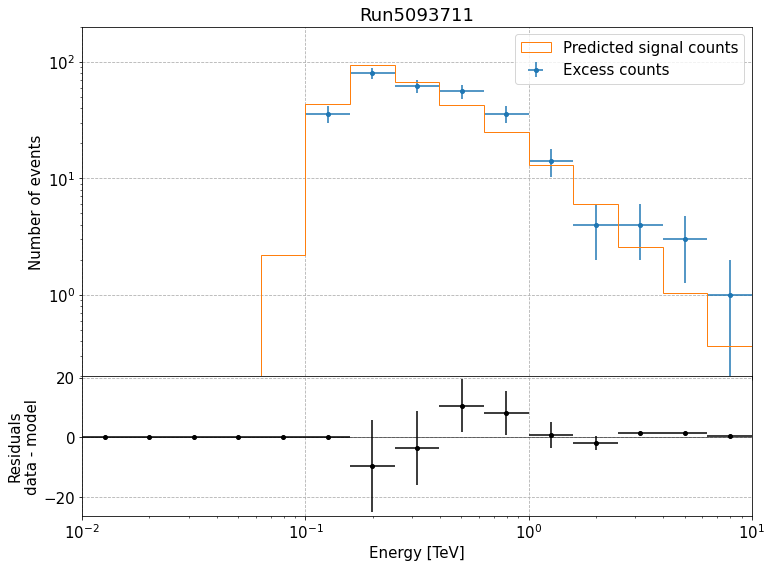

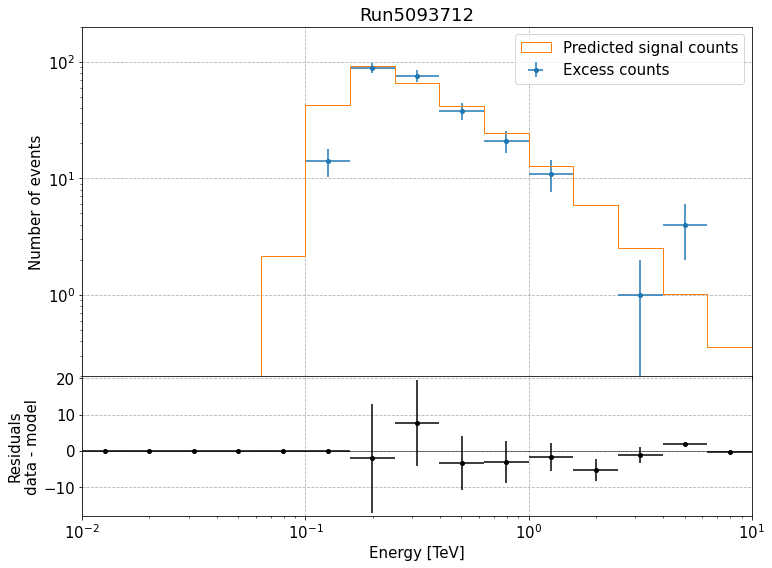

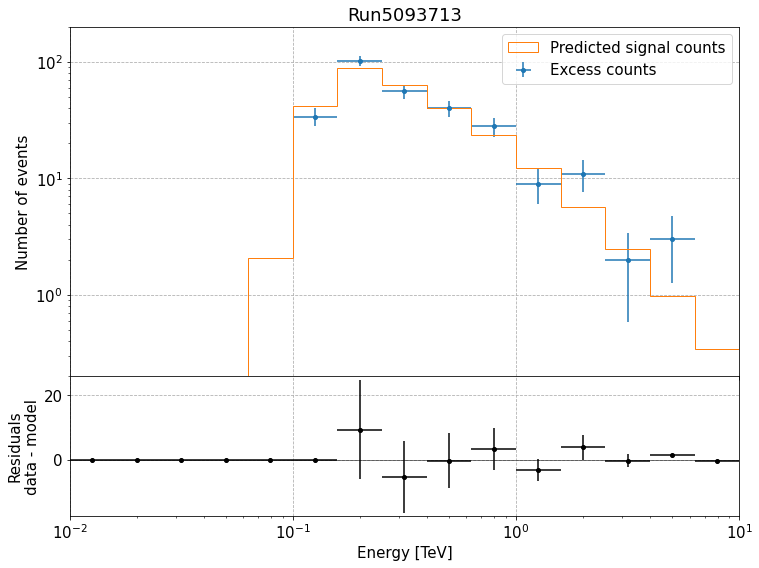

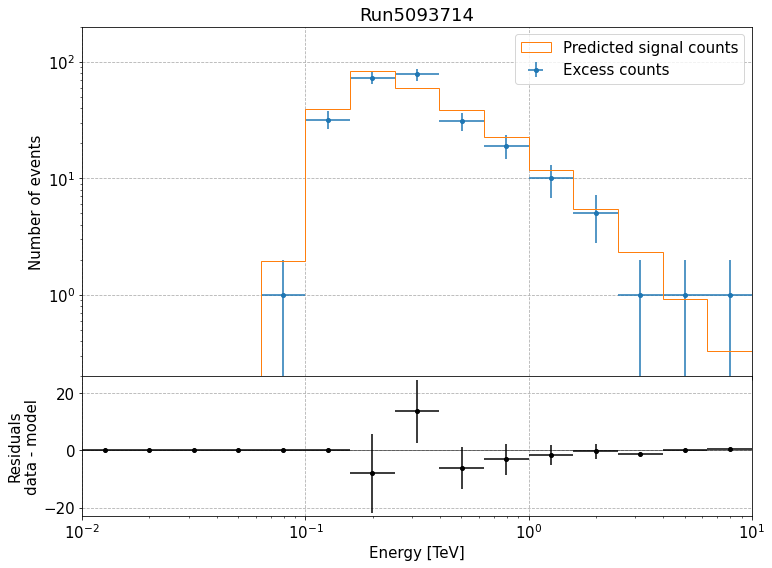

In [14]:
for i_data, dataset in enumerate(datasets):
    
    plt.figure()

    ax_spectrum, ax_residuals = datasets[i_data].plot_fit()

    ax_spectrum.set_title(f'Run{dataset.name}')
    ax_spectrum.set_ylabel('Number of events')
    ax_spectrum.set_ylim(0.2, 200)
    ax_spectrum.grid()

    plt.setp(ax_spectrum.get_xticklabels(), visible=False)

    ax_residuals.grid()

    plt.subplots_adjust(hspace=0)

# Compute flux points

In [15]:
# === Settings ===
energy_edges = u.Quantity(np.logspace(-1, 1, 11), u.TeV)

# === Main ===
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source='crab', selection_optional='all',
)

flux_points = fpe.run(datasets=datasets)
flux_points_dataset = FluxPointsDataset(data=flux_points, models=model_best_joint)

In [16]:
flux_points.to_table(sed_type='e2dnde', formatted=True)

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred [4],npred_excess [4],stat,is_ul,counts [4],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
0.126,0.100,0.158,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,False,0.0 .. 0.0,False,0.200 .. 5.000,nan .. nan
0.200,0.158,0.251,6.090e-11,5.299e-12,5.324e-12,5.278e-12,7.162e-11,135.810,11.654,165.69935632264236 .. 137.37292492708562,89.76927 .. 80.59367,1.991,False,159.0 .. 132.0,True,0.200 .. 5.000,87.565 .. 1319.218
0.316,0.251,0.398,5.457e-11,4.611e-12,4.645e-12,4.579e-12,6.394e-11,145.884,12.078,114.16246947039843 .. 89.42777160879758,71.81906 .. 64.47821,3.494,False,107.0 .. 100.0,True,0.200 .. 5.000,101.339 .. 959.652
0.501,0.398,0.631,3.875e-11,3.833e-12,3.885e-12,3.786e-12,4.663e-11,111.431,10.556,56.41347202196963 .. 48.2316263452015,42.872353 .. 38.490234,3.654,False,67.0 .. 42.0,True,0.200 .. 5.000,76.496 .. 693.741
0.794,0.631,1.000,2.932e-11,3.679e-12,3.747e-12,3.620e-12,3.699e-11,71.133,8.434,37.655419800513286 .. 28.128632007754376,26.474642 .. 23.768585,3.438,False,45.0 .. 24.0,True,0.200 .. 5.000,50.940 .. 393.380
1.259,1.000,1.585,1.655e-11,2.856e-12,2.960e-12,2.764e-12,2.269e-11,39.040,6.248,13.785723835239224 .. 11.218378426973615,11.40301 .. 10.237473,0.668,False,16.0 .. 11.0,True,0.200 .. 5.000,24.748 .. 247.526
1.995,1.585,2.512,9.586e-12,3.265e-12,3.398e-12,3.160e-12,1.667e-11,9.383,3.063,5.60759824764613 .. 5.360001753771828,4.7053585 .. 4.224409,6.616,False,5.0 .. 6.0,True,0.200 .. 5.000,11.879 .. 112.706
3.162,2.512,3.981,6.715e-12,2.550e-12,2.813e-12,2.741e-12,1.288e-11,6.170,2.484,2.3112309142389953 .. 2.0749927978998874,2.311231 .. 2.074993,2.009,False,4.0 .. 1.0,True,0.200 .. 5.000,5.608 .. 49.376


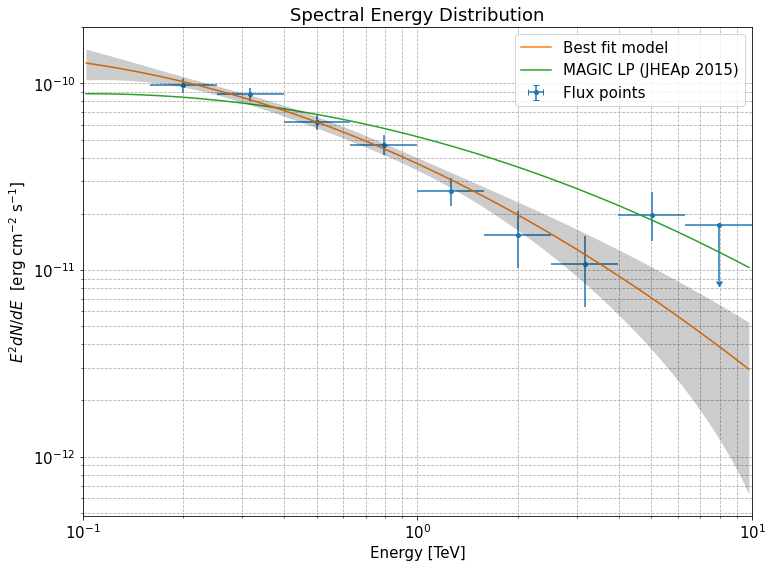

In [17]:
plt.figure()

plot_kwargs = {
    'sed_type': 'e2dnde',
    'yunits': u.Unit('erg cm-2 s-1'),
}

# Plot the computed flux points:
ax = flux_points_dataset.plot_spectrum(kwargs_model=plot_kwargs)

# Plot the MAGIC reference curve:
create_crab_spectral_model('magic_lp').plot(
    ax=ax, energy_bounds=u.Quantity([0.1, 10], u.TeV),
    label='MAGIC LP (JHEAp 2015)', **plot_kwargs,
)

ax.set_title('Spectral Energy Distribution')
ax.set_ylabel('$E^2dN/dE$  [erg cm$^{-2}$ s$^{-1}$]')
ax.grid(which='both')
ax.legend()